## Load Raw Data

In [68]:
import zipfile
import pandas as pd

with zipfile.ZipFile("/content/drive/MyDrive/Student/Mohit/Dataset/Skin_Cancer_Malignant_vs_Benign/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")



## Required External Libs

In [69]:
!pip install flwr[simulation]
!pip install torch
!pip install torchvision

## Started Federated Learning Models Code

In [70]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()


Training on cuda
Flower 1.23.0 / PyTorch 2.8.0+cu126


### Data Pre Processing

Federated Data Partitioning with Stratification

✅ Loaded CSVs:
Train: 2637 | Val: 330 | Test: 330
Clients: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Client 0 -> Train samples: 264, Val samples: 33


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


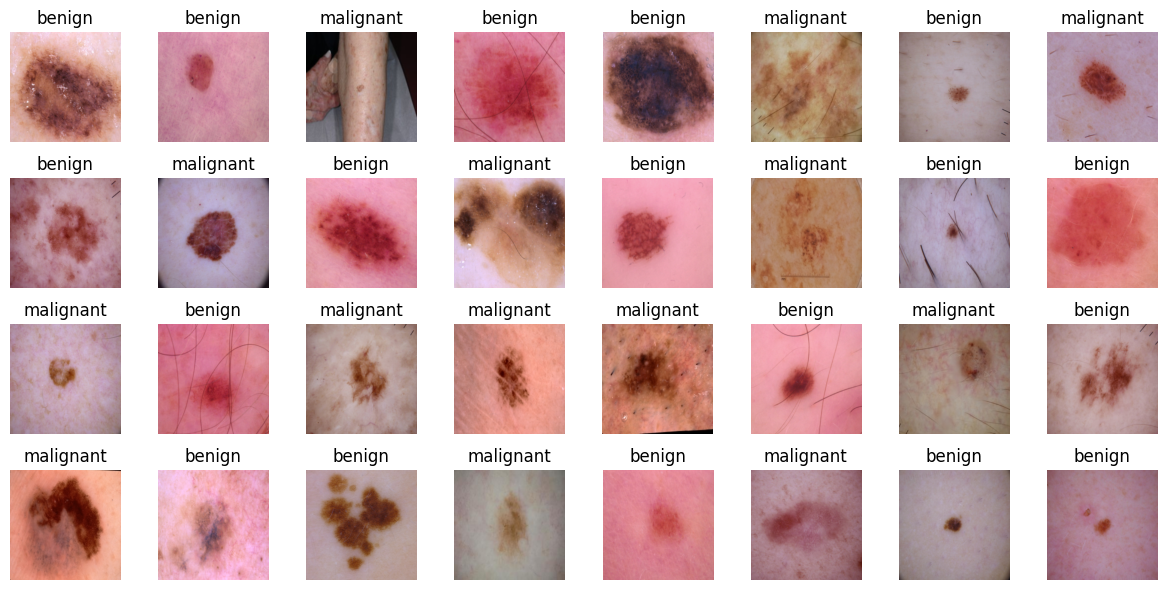


📊 Label distribution per client (Train):
Client 0: {'benign': 144, 'malignant': 120} (Total=264)
Client 1: {'benign': 144, 'malignant': 120} (Total=264)
Client 2: {'benign': 144, 'malignant': 120} (Total=264)
Client 3: {'benign': 144, 'malignant': 120} (Total=264)
Client 4: {'benign': 144, 'malignant': 120} (Total=264)
Client 5: {'benign': 144, 'malignant': 120} (Total=264)
Client 6: {'benign': 144, 'malignant': 120} (Total=264)
Client 7: {'benign': 144, 'malignant': 119} (Total=263)
Client 8: {'benign': 144, 'malignant': 119} (Total=263)
Client 9: {'benign': 144, 'malignant': 119} (Total=263)

📊 Label distribution per client (Validation):
Client 0: {'benign': 19, 'malignant': 14} (Total=33)
Client 1: {'benign': 19, 'malignant': 14} (Total=33)
Client 2: {'benign': 19, 'malignant': 14} (Total=33)
Client 3: {'benign': 19, 'malignant': 14} (Total=33)
Client 4: {'benign': 20, 'malignant': 13} (Total=33)
Client 5: {'benign': 20, 'malignant': 13} (Total=33)
Client 6: {'benign': 20, 'maligna

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [71]:
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# -----------------------------
# CONFIGS
# -----------------------------
N_CLASS = 2
N_ROUND = 5
NUM_CLIENTS = 10
BATCH_SIZE = 32
EPOCH = 10

CSV_BASE_PATH = "/content/drive/MyDrive/Student/Mohit/Dataset/Federated_Learning_Project_2/Processed_CSV/"

# -----------------------------
# TRANSFORMS
# -----------------------------
pytorch_transforms = transforms.Compose([
    transforms.Resize((299, 299)), #just for this inception models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# -----------------------------
# CUSTOM DATASET CLASS
# -----------------------------
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_to_idx = {'benign': 0, 'malignant': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['file_path']
        label = self.label_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
    @property
    def classes(self):
        return list(self.label_to_idx.keys())


# -----------------------------
# LOAD CSV FILES
# -----------------------------
train_df = pd.read_csv(CSV_BASE_PATH + "train_df_with_client.csv")
val_df = pd.read_csv(CSV_BASE_PATH + "val_df_with_client.csv")
test_df = pd.read_csv(CSV_BASE_PATH + "test_df_with_client.csv")

print("✅ Loaded CSVs:")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("Clients:", sorted(train_df['client_id'].unique()))

# -----------------------------
# FUNCTION: LOAD DATA FOR ONE CLIENT
# -----------------------------
def load_datasets(client_id):
    """Return train and validation DataLoaders for a specific client."""
    client_train = train_df[train_df['client_id'] == client_id]
    client_val = val_df[val_df['client_id'] == client_id]

    train_dataset = CustomImageDataset(client_train, transform=pytorch_transforms)
    val_dataset = CustomImageDataset(client_val, transform=pytorch_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader

# -----------------------------
# EXAMPLE: LOAD DATA FOR CLIENT 0
# -----------------------------
trainloader, valloader = load_datasets(0)

print(f"Client 0 -> Train samples: {len(trainloader.dataset)}, Val samples: {len(valloader.dataset)}")

# -----------------------------
# VISUALIZE A BATCH (OPTIONAL)
# -----------------------------
batch = next(iter(valloader))
images, labels = batch

# Convert labels to class names for display
idx_to_label = {0: "benign", 1: "malignant"}

# Denormalize for visualization
images = images.permute(0, 2, 3, 1).numpy()
images = (images * 0.5 + 0.5).clip(0, 1)

fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(idx_to_label[labels[i].item()])
        ax.axis("off")
plt.tight_layout()
plt.show()

# -----------------------------
# CHECK DISTRIBUTION PER CLIENT
# -----------------------------
print("\n📊 Label distribution per client (Train):")
for cid in sorted(train_df['client_id'].unique()):
    subset = train_df[train_df['client_id'] == cid]
    dist = subset['label'].value_counts().to_dict()
    print(f"Client {cid}: {dist} (Total={len(subset)})")

print("\n📊 Label distribution per client (Validation):")
for cid in sorted(val_df['client_id'].unique()):
    subset = val_df[val_df['client_id'] == cid]
    dist = subset['label'].value_counts().to_dict()
    print(f"Client {cid}: {dist} (Total={len(subset)})")

# -----------------------------
# VAL SET (GLOBAL EVALUATION)
# -----------------------------
val_dataset = CustomImageDataset(test_df, transform=pytorch_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# TEST SET (GLOBAL EVALUATION)
# -----------------------------
test_dataset = CustomImageDataset(test_df, transform=pytorch_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"\n🧪 Global Test Set -> Total samples: {len(test_dataset)}")


### Model Creating

In [72]:
import torch.nn as nn
from torchvision import models
from torchvision.models import (
    ResNet50_Weights, DenseNet201_Weights, VGG19_Weights,
    EfficientNet_B0_Weights, MobileNet_V2_Weights, Inception_V3_Weights
)

# ------------------------- Helper -------------------------
def determineFinalLayer(model):
    """Find the number of input features for the last linear layer."""
    if hasattr(model, "fc"):  # ResNet, Inception
        return model.fc.in_features
    elif hasattr(model, "classifier"):
        if isinstance(model.classifier, nn.Linear):  # DenseNet, MobileNet
            return model.classifier.in_features
        elif isinstance(model.classifier, nn.Sequential):  # VGG, EfficientNet
            # Find last linear layer in Sequential
            for layer in reversed(model.classifier):
                if isinstance(layer, nn.Linear):
                    return layer.in_features
    raise NotImplementedError("Unknown model architecture — can't determine final layer")


# ------------------------- Main Model Factory -------------------------
def createTensorModel(num_classes=2):
    """Create and customize a CNN model for classification."""

    MODEL_NAME = "inception_v3"

    if MODEL_NAME == "resnet50":
        weights = ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        model.fc = nn.Linear(determineFinalLayer(model), num_classes)

    elif MODEL_NAME == "densenet201":
        weights = DenseNet201_Weights.DEFAULT
        model = models.densenet201(weights=weights)
        model.classifier = nn.Linear(determineFinalLayer(model), num_classes)

    elif MODEL_NAME == "vgg19":
        weights = VGG19_Weights.DEFAULT
        model = models.vgg19(weights=weights)
        model.classifier[-1] = nn.Linear(determineFinalLayer(model), num_classes)

    elif MODEL_NAME == "mobilenet_v2":
        weights = MobileNet_V2_Weights.DEFAULT
        model = models.mobilenet_v2(weights=weights)
        model.classifier[-1] = nn.Linear(determineFinalLayer(model), num_classes)

    elif MODEL_NAME == "inception_v3":
        weights = Inception_V3_Weights.DEFAULT
        model = models.inception_v3(weights=weights, aux_logits=True)
        # Disable auxiliary classifier manually
        model.aux_logits = False
        model.AuxLogits = None
        model.fc = nn.Linear(determineFinalLayer(model), num_classes)
        input_size = 299


    elif MODEL_NAME == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        model.classifier[1] = nn.Linear(determineFinalLayer(model), num_classes)

    else:
        raise ValueError(f"Model {MODEL_NAME} not supported")

    return model


In [73]:
def train(net, trainloader, epochs=1, verbose=False):
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()       #loss

            running_loss += loss.item() * labels.size(0)    #adding losses for per image
            running_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_samples += labels.size(0)

    # Avoid division by zero
    if total_samples == 0:
        return 0.0, 0.0

    avg_loss = running_loss / total_samples
    avg_acc = running_correct / total_samples
    if verbose:
        print(f"[train] loss={avg_loss:.4f}, acc={avg_acc:.4f}")
    return avg_loss, avg_acc


In [74]:
# Testing function
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:     # <-- fixed here
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy


In [75]:
#for server
from collections import OrderedDict
import numpy as np

def set_parameters(net, parameters: list[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})  #{layer name: tensor[parameters]}
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> list[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


In [76]:
from flwr.client import NumPyClient
from pathlib import Path
# all_round_metrics = []

class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader, client_id):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.client_id = client_id


    def get_parameters(self, config):
        return get_parameters(self.net)         #return the current local parameters

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        # train() now returns avg train loss and accuracy
        train_loss, train_acc = train(self.net, self.trainloader, epochs=EPOCH)

        # Return metrics dict with train keys
        return get_parameters(self.net), len(self.trainloader.dataset), {
            "train_loss": float(train_loss),
            "train_accuracy": float(train_acc),
        }

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        val_loss, val_acc = test(self.net, self.valloader)
        # Must return loss in metrics so server can aggregate it
        return float(val_loss), len(self.valloader.dataset), {
            "accuracy": float(val_acc),
            "loss": float(val_loss),
        }


In [77]:
from flwr.common import Context
from flwr.client import Client

def client_fn(context: Context) -> Client:
    partition_id = context.node_config["partition-id"]
    trainloader, valloader = load_datasets(partition_id)
    net = createTensorModel(num_classes=N_CLASS).to(DEVICE)
    return FlowerClient(net, trainloader, valloader, client_id=partition_id).to_client()


In [78]:
from flwr.client import ClientApp

# Wrap the client function into a ClientApp
client = ClientApp(client_fn=client_fn)


In [79]:
from flwr.simulation import run_simulation

# Configure resources per client
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}


In [80]:
from typing import List, Tuple, Dict
train_metrics_per_round = []
all_round_metrics = []  # validation metrics as before

def aggregate_train_metrics(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
    # Debug print to see what clients returned
    # (comment out in final runs if noisy)
    print("DEBUG aggregate_train_metrics received:", metrics)

    total_examples = sum(n for n, _ in metrics)
    if total_examples == 0:
        avg_train_loss = 0.0
        avg_train_acc = 0.0
    else:
        avg_train_loss = sum(n * m.get("train_loss", 0.0) for n, m in metrics) / total_examples
        avg_train_acc = sum(n * m.get("train_accuracy", 0.0) for n, m in metrics) / total_examples

    train_metrics_per_round.append((len(train_metrics_per_round) + 1, avg_train_loss, avg_train_acc))

    # Return a dictionary expected by Flower (can be empty or include agg values)
    return {"train_loss": avg_train_loss, "train_accuracy": avg_train_acc}

In [81]:
def weighted_average(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
    # metrics: List[(num_examples, {"accuracy":..., "loss":...}), ...]
    total_examples = sum(n for n, _ in metrics)
    if total_examples == 0:
        avg_acc = 0.0
        avg_loss = 0.0
    else:
        avg_acc = sum(n * m.get("accuracy", 0.0) for n, m in metrics) / total_examples
        avg_loss = sum(n * m.get("loss", 0.0) for n, m in metrics) / total_examples

    all_round_metrics.append((len(all_round_metrics) + 1, avg_loss, avg_acc))
    return {"accuracy": avg_acc}


In [82]:
import os

os.makedirs("/content/global_models", exist_ok=True)
print("Created /content/global_models directory if it did not exist.")

Created /content/global_models directory if it did not exist.


In [83]:
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg
from flwr.common import parameters_to_ndarrays
import torch

def server_fn(context: Context) -> ServerAppComponents:
    """ServerApp with FedAvg that saves the global model each round."""

    class SaveFedAvg(FedAvg):
        """FedAvg that saves aggregated global model after each round."""

        def aggregate_fit(self, server_round, results, failures):
            aggregated_result = super().aggregate_fit(server_round, results, failures)

            # Make sure aggregation succeeded
            if aggregated_result is not None:
                aggregated_parameters, _ = aggregated_result

                # Convert to NumPy arrays
                ndarrays = parameters_to_ndarrays(aggregated_parameters)

                # Create and load into model
                model = createTensorModel(num_classes=N_CLASS)  # your model class
                set_parameters(model, ndarrays)  # your helper to map ndarrays → model.state_dict()

                save_path = f"/content/global_models/global_model_round_{server_round}.pth"
                torch.save(model.state_dict(), save_path)
                # torch.save(model, f"/content/global_models/global_model_full_round_{server_round}.pth")
                print(f"💾 [SERVER] Saved global model after round {server_round} → {save_path}")

            return aggregated_result

    strategy = SaveFedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=4,
        min_available_clients=NUM_CLIENTS,
        evaluate_metrics_aggregation_fn=weighted_average,
        fit_metrics_aggregation_fn=aggregate_train_metrics,
    )

    config = ServerConfig(num_rounds=N_ROUND)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)


In [84]:
# Run the federated learning simulation and capture history + final params
history = run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=12082) 2025-11-12 16:51:49.376053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=12082) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=12082) E0000 00:00:1762966309.395490   12082 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

DEBUG aggregate_train_metrics received: [(263, {'train_loss': 0.2599306530598905, 'train_accuracy': 0.8965779467680608}), (263, {'train_loss': 0.3796606199964598, 'train_accuracy': 0.8216730038022814}), (264, {'train_loss': 0.2580296046806104, 'train_accuracy': 0.8981060606060606}), (263, {'train_loss': 0.2825968974330126, 'train_accuracy': 0.8779467680608365}), (264, {'train_loss': 0.29777872914617715, 'train_accuracy': 0.8799242424242424}), (264, {'train_loss': 0.2524269253015518, 'train_accuracy': 0.8996212121212122}), (264, {'train_loss': 0.20959973389452155, 'train_accuracy': 0.9090909090909091}), (264, {'train_loss': 0.26645726075000836, 'train_accuracy': 0.8875}), (264, {'train_loss': 0.28747086850079623, 'train_accuracy': 0.8651515151515151}), (264, {'train_loss': 0.38123665352662406, 'train_accuracy': 0.8246212121212121})]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


💾 [SERVER] Saved global model after round 1 → /content/global_models/global_model_round_1.pth


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


DEBUG aggregate_train_metrics received: [(264, {'train_loss': 0.17240507306926178, 'train_accuracy': 0.9375}), (264, {'train_loss': 0.19110643573839103, 'train_accuracy': 0.9227272727272727}), (264, {'train_loss': 0.19175624014019516, 'train_accuracy': 0.9318181818181818}), (264, {'train_loss': 0.1614663218317384, 'train_accuracy': 0.9397727272727273}), (264, {'train_loss': 0.222049621458758, 'train_accuracy': 0.9102272727272728}), (264, {'train_loss': 0.24930023510347712, 'train_accuracy': 0.8984848484848484}), (263, {'train_loss': 0.19791725614026698, 'train_accuracy': 0.9216730038022813}), (263, {'train_loss': 0.1697353626321647, 'train_accuracy': 0.9357414448669201}), (264, {'train_loss': 0.23475168480566053, 'train_accuracy': 0.9079545454545455}), (263, {'train_loss': 0.25155126914495296, 'train_accuracy': 0.9003802281368821})]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


💾 [SERVER] Saved global model after round 2 → /content/global_models/global_model_round_2.pth


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


DEBUG aggregate_train_metrics received: [(263, {'train_loss': 0.16877420700859888, 'train_accuracy': 0.9433460076045628}), (264, {'train_loss': 0.1465343631606436, 'train_accuracy': 0.9481060606060606}), (264, {'train_loss': 0.16922775228140932, 'train_accuracy': 0.9321969696969697}), (264, {'train_loss': 0.12973143354509817, 'train_accuracy': 0.9446969696969697}), (264, {'train_loss': 0.15030100267860247, 'train_accuracy': 0.9446969696969697}), (263, {'train_loss': 0.17714623043264047, 'train_accuracy': 0.9326996197718631}), (263, {'train_loss': 0.16235700631407957, 'train_accuracy': 0.9376425855513308}), (264, {'train_loss': 0.19547418205236847, 'train_accuracy': 0.9242424242424242}), (264, {'train_loss': 0.17400868607289863, 'train_accuracy': 0.9318181818181818}), (264, {'train_loss': 0.16616666528650306, 'train_accuracy': 0.9367424242424243})]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


💾 [SERVER] Saved global model after round 3 → /content/global_models/global_model_round_3.pth


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


DEBUG aggregate_train_metrics received: [(264, {'train_loss': 0.1318330889186737, 'train_accuracy': 0.9534090909090909}), (263, {'train_loss': 0.13294031141182414, 'train_accuracy': 0.9547528517110266}), (264, {'train_loss': 0.11955079687477062, 'train_accuracy': 0.9553030303030303}), (263, {'train_loss': 0.1174090639931086, 'train_accuracy': 0.9627376425855513}), (264, {'train_loss': 0.13908598336927366, 'train_accuracy': 0.9473484848484849}), (264, {'train_loss': 0.11370318232837952, 'train_accuracy': 0.9583333333333334}), (264, {'train_loss': 0.11495064027170002, 'train_accuracy': 0.959469696969697}), (264, {'train_loss': 0.13016752110455523, 'train_accuracy': 0.956060606060606}), (263, {'train_loss': 0.12445173963449344, 'train_accuracy': 0.9543726235741445}), (264, {'train_loss': 0.10814725267277522, 'train_accuracy': 0.9602272727272727})]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


💾 [SERVER] Saved global model after round 4 → /content/global_models/global_model_round_4.pth


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


DEBUG aggregate_train_metrics received: [(264, {'train_loss': 0.06345911937286004, 'train_accuracy': 0.9772727272727273}), (263, {'train_loss': 0.14807883422014378, 'train_accuracy': 0.9448669201520913}), (264, {'train_loss': 0.06801367223573228, 'train_accuracy': 0.9768939393939394}), (264, {'train_loss': 0.07227339856749908, 'train_accuracy': 0.9738636363636364}), (264, {'train_loss': 0.10914663122190783, 'train_accuracy': 0.9625}), (264, {'train_loss': 0.12698975507395738, 'train_accuracy': 0.9636363636363636}), (264, {'train_loss': 0.09349738619374957, 'train_accuracy': 0.9662878787878788}), (264, {'train_loss': 0.10141112087541401, 'train_accuracy': 0.9647727272727272}), (263, {'train_loss': 0.09768022837917614, 'train_accuracy': 0.9692015209125475}), (263, {'train_loss': 0.07988375103589813, 'train_accuracy': 0.973384030418251})]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


💾 [SERVER] Saved global model after round 5 → /content/global_models/global_model_round_5.pth


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2715.28s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.6001970589160919
INFO :      		round 2: 0.4839101329445839
INFO :      		round 3: 0.4671738505363464
INFO :      		round 4: 0.5424749560654163
INFO :      		round 5: 0.5525972876697779
INFO :      	History (metrics, distributed, fit):
INFO :      	{'train_accuracy': [(1, 0.8760333712552142),
INFO :      	                    (2, 0.9206295032233598),
INFO :      	                    (3, 0.9376185058778915),
INFO :      	                    (4, 0.9562002275312855),
INFO :      	                    (5, 0.9672734167614713)],
INFO :      	 'train_loss': [(1, 0.2874961811338562),
INFO :      	                (2, 0.20420145018172448),
INFO :      	                (3, 0.16396594848999435),
INFO :      	                (4, 0.12322201295334202),
INFO :      	                (5, 0.0960

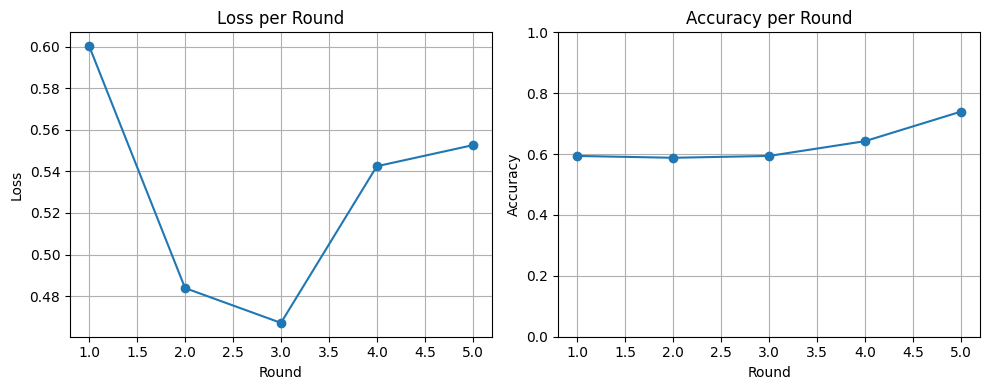

In [85]:
rounds = [r for r, _, _ in all_round_metrics]
losses = [l for _, l, _ in all_round_metrics]
accuracies = [a for _, _, a in all_round_metrics]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(rounds, losses, marker="o")
plt.title("Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rounds, accuracies, marker="o")
plt.title("Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.ylim(0,1.0)
plt.grid(True)
plt.tight_layout()
plt.show()


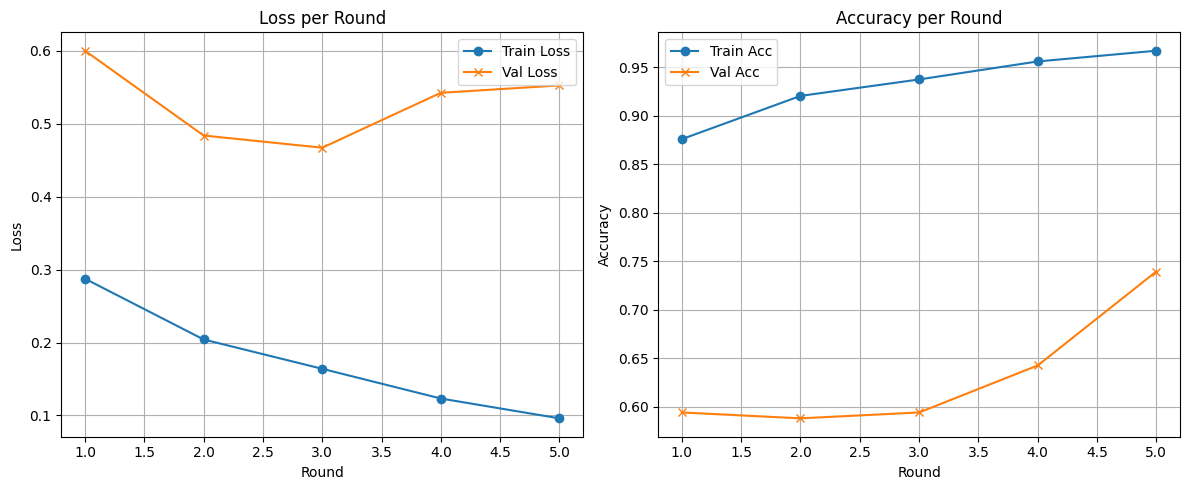

In [86]:
# After simulation finishes
rounds = [r for r, _, _ in train_metrics_per_round]
train_losses = [l for _, l, _ in train_metrics_per_round]
train_accs = [a for _, _, a in train_metrics_per_round]

val_rounds = [r for r, _, _ in all_round_metrics]
val_losses = [l for _, l, _ in all_round_metrics]
val_accs = [a for _, _, a in all_round_metrics]

# You probably want to align rounds: both should have same length (num_rounds)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(rounds, train_losses, marker='o', label="Train Loss")
plt.plot(val_rounds, val_losses, marker='x', label="Val Loss")
plt.xlabel("Round"); plt.ylabel("Loss"); plt.title("Loss per Round"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rounds, train_accs, marker='o', label="Train Acc")
plt.plot(val_rounds, val_accs, marker='x', label="Val Acc")
plt.xlabel("Round"); plt.ylabel("Accuracy"); plt.title("Accuracy per Round"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


## Global Model Performance : Val Set

In [87]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# -------------------- EVALUATION FUNCTION --------------------
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    acc = np.mean(np.array(y_true) == np.array(y_pred))
    return acc, y_true, y_pred

In [88]:
round_models = []
for r in range(1, N_ROUND+1):
    print(f"Round: {r} loaded")
    model = createTensorModel(num_classes=N_CLASS)  # same architecture used in training
    model.load_state_dict(torch.load(f"/content/global_models/global_model_round_{r}.pth", map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    round_models.append((r, model))
print(f"✅ Loaded {len(round_models)} global models")


Round: 1 loaded
Round: 2 loaded
Round: 3 loaded
Round: 4 loaded
Round: 5 loaded
✅ Loaded 5 global models


In [89]:
for round_num, model in round_models:
    print(f"\n================= Evaluating Global Model: Round {round_num} =================")

    client_accuracies = []
    all_y_true = []
    all_y_pred = []

    for client_id in range(NUM_CLIENTS):
        _, valloader = load_datasets(client_id)  # or load_testset(client_id) if you have one
        acc, y_true, y_pred = evaluate_model(model, valloader)
        client_accuracies.append(acc)
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

        print(f"Client {client_id} Accuracy: {acc:.4f}")

    avg_acc = np.mean(client_accuracies)
    print(f"\nAverage Accuracy Across Clients (Round {round_num}): {avg_acc:.4f}")

    # Global metrics
    report = classification_report(all_y_true, all_y_pred, digits=4)
    cm = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nGlobal Classification Report for Round {round_num}:\n{report}")
    print(f"Confusion Matrix for Round {round_num}:\n{cm}")



================= Evaluating Global Model: Round 1 =================
Client 0 Accuracy: 0.5758
Client 1 Accuracy: 0.5758
Client 2 Accuracy: 0.5758
Client 3 Accuracy: 0.5758
Client 4 Accuracy: 0.6061
Client 5 Accuracy: 0.6061
Client 6 Accuracy: 0.6061
Client 7 Accuracy: 0.6061
Client 8 Accuracy: 0.6061
Client 9 Accuracy: 0.6061

Average Accuracy Across Clients (Round 1): 0.5939

Global Classification Report for Round 1:
              precision    recall  f1-score   support

           0     0.5939    1.0000    0.7452       196
           1     0.0000    0.0000    0.0000       134

    accuracy                         0.5939       330
   macro avg     0.2970    0.5000    0.3726       330
weighted avg     0.3528    0.5939    0.4426       330

Confusion Matrix for Round 1:
[[196   0]
 [134   0]]

================= Evaluating Global Model: Round 2 =================


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/jupyter_c

Client 0 Accuracy: 0.5758
Client 1 Accuracy: 0.5758
Client 2 Accuracy: 0.5758
Client 3 Accuracy: 0.5758
Client 4 Accuracy: 0.6061
Client 5 Accuracy: 0.6061
Client 6 Accuracy: 0.6061
Client 7 Accuracy: 0.6061
Client 8 Accuracy: 0.6061
Client 9 Accuracy: 0.6061

Average Accuracy Across Clients (Round 2): 0.5939

Global Classification Report for Round 2:
              precision    recall  f1-score   support

           0     0.5939    1.0000    0.7452       196
           1     0.0000    0.0000    0.0000       134

    accuracy                         0.5939       330
   macro avg     0.2970    0.5000    0.3726       330
weighted avg     0.3528    0.5939    0.4426       330

Confusion Matrix for Round 2:
[[196   0]
 [134   0]]

================= Evaluating Global Model: Round 3 =================


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/jupyter_c

Client 0 Accuracy: 0.5758
Client 1 Accuracy: 0.5758
Client 2 Accuracy: 0.5758
Client 3 Accuracy: 0.5758
Client 4 Accuracy: 0.6061
Client 5 Accuracy: 0.6061
Client 6 Accuracy: 0.6061
Client 7 Accuracy: 0.6061
Client 8 Accuracy: 0.6061
Client 9 Accuracy: 0.6061

Average Accuracy Across Clients (Round 3): 0.5939

Global Classification Report for Round 3:
              precision    recall  f1-score   support

           0     0.5939    1.0000    0.7452       196
           1     0.0000    0.0000    0.0000       134

    accuracy                         0.5939       330
   macro avg     0.2970    0.5000    0.3726       330
weighted avg     0.3528    0.5939    0.4426       330

Confusion Matrix for Round 3:
[[196   0]
 [134   0]]

================= Evaluating Global Model: Round 4 =================


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/jupyter_c

Client 0 Accuracy: 0.6364
Client 1 Accuracy: 0.6364
Client 2 Accuracy: 0.6970
Client 3 Accuracy: 0.6061
Client 4 Accuracy: 0.6364
Client 5 Accuracy: 0.6364
Client 6 Accuracy: 0.6364
Client 7 Accuracy: 0.6970
Client 8 Accuracy: 0.6061
Client 9 Accuracy: 0.6667

Average Accuracy Across Clients (Round 4): 0.6455

Global Classification Report for Round 4:
              precision    recall  f1-score   support

           0     0.6262    1.0000    0.7701       196
           1     1.0000    0.1269    0.2252       134

    accuracy                         0.6455       330
   macro avg     0.8131    0.5634    0.4977       330
weighted avg     0.7780    0.6455    0.5488       330

Confusion Matrix for Round 4:
[[196   0]
 [117  17]]

================= Evaluating Global Model: Round 5 =================


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 0 Accuracy: 0.6364
Client 1 Accuracy: 0.7576
Client 2 Accuracy: 0.7576
Client 3 Accuracy: 0.7576
Client 4 Accuracy: 0.7273
Client 5 Accuracy: 0.6970
Client 6 Accuracy: 0.7576
Client 7 Accuracy: 0.6970
Client 8 Accuracy: 0.7576
Client 9 Accuracy: 0.7576

Average Accuracy Across Clients (Round 5): 0.7303

Global Classification Report for Round 5:
              precision    recall  f1-score   support

           0     0.6890    0.9949    0.8142       196
           1     0.9787    0.3433    0.5083       134

    accuracy                         0.7303       330
   macro avg     0.8339    0.6691    0.6612       330
weighted avg     0.8067    0.7303    0.6900       330

Confusion Matrix for Round 5:
[[195   1]
 [ 88  46]]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


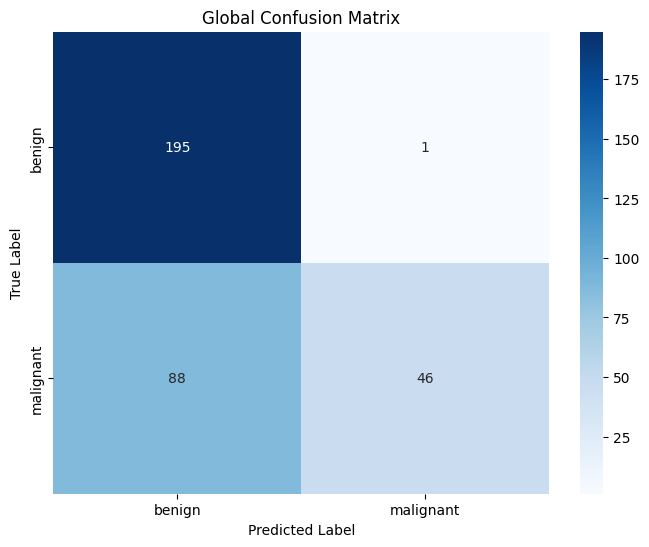

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Global Confusion Matrix')
plt.show()

## Global Model Performance : Test Set

In [91]:
from torch.utils.data import DataLoader


def load_test_datasets(client_id):
    client_test = test_df[test_df['client_id'] == client_id]
    test_dataset = CustomImageDataset(client_test, transform=pytorch_transforms)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return test_loader


In [92]:
for round_num, model in round_models:
    print(f"\n================= Evaluating Global Model: Round {round_num} =================")

    client_accuracies = []
    all_y_true = []
    all_y_pred = []

    for client_id in range(NUM_CLIENTS):
        testloader = load_test_datasets(client_id)
        acc, y_true, y_pred = evaluate_model(model, testloader)
        client_accuracies.append(acc)
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

        print(f"Client {client_id} Accuracy: {acc:.4f}")

    avg_acc = np.mean(client_accuracies)
    print(f"\nAverage Accuracy Across Clients (Round {round_num}): {avg_acc:.4f}")

    # Global metrics
    report = classification_report(all_y_true, all_y_pred, digits=4)
    test_cm = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nGlobal Classification Report for Round {round_num}:\n{report}")
    print(f"Confusion Matrix for Round {round_num}:\n{cm}")



================= Evaluating Global Model: Round 1 =================
Client 0 Accuracy: 0.4848
Client 1 Accuracy: 0.4848
Client 2 Accuracy: 0.4848
Client 3 Accuracy: 0.4848
Client 4 Accuracy: 0.4848
Client 5 Accuracy: 0.4848
Client 6 Accuracy: 0.5152
Client 7 Accuracy: 0.5152
Client 8 Accuracy: 0.5152
Client 9 Accuracy: 0.5152

Average Accuracy Across Clients (Round 1): 0.4970

Global Classification Report for Round 1:
              precision    recall  f1-score   support

           0     0.4970    1.0000    0.6640       164
           1     0.0000    0.0000    0.0000       166

    accuracy                         0.4970       330
   macro avg     0.2485    0.5000    0.3320       330
weighted avg     0.2470    0.4970    0.3300       330

Confusion Matrix for Round 1:
[[195   1]
 [ 88  46]]

================= Evaluating Global Model: Round 2 =================


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/jupyter_c

Client 0 Accuracy: 0.4848
Client 1 Accuracy: 0.4848
Client 2 Accuracy: 0.4848
Client 3 Accuracy: 0.4848
Client 4 Accuracy: 0.4848
Client 5 Accuracy: 0.4848
Client 6 Accuracy: 0.5152
Client 7 Accuracy: 0.5152
Client 8 Accuracy: 0.5152
Client 9 Accuracy: 0.5152

Average Accuracy Across Clients (Round 2): 0.4970

Global Classification Report for Round 2:
              precision    recall  f1-score   support

           0     0.4970    1.0000    0.6640       164
           1     0.0000    0.0000    0.0000       166

    accuracy                         0.4970       330
   macro avg     0.2485    0.5000    0.3320       330
weighted avg     0.2470    0.4970    0.3300       330

Confusion Matrix for Round 2:
[[195   1]
 [ 88  46]]

================= Evaluating Global Model: Round 3 =================


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/jupyter_c

Client 0 Accuracy: 0.5152
Client 1 Accuracy: 0.4848
Client 2 Accuracy: 0.4848
Client 3 Accuracy: 0.4848
Client 4 Accuracy: 0.4848
Client 5 Accuracy: 0.4848
Client 6 Accuracy: 0.5455
Client 7 Accuracy: 0.5152
Client 8 Accuracy: 0.5152
Client 9 Accuracy: 0.5455

Average Accuracy Across Clients (Round 3): 0.5061

Global Classification Report for Round 3:
              precision    recall  f1-score   support

           0     0.5015    1.0000    0.6680       164
           1     1.0000    0.0181    0.0355       166

    accuracy                         0.5061       330
   macro avg     0.7508    0.5090    0.3518       330
weighted avg     0.7523    0.5061    0.3498       330

Confusion Matrix for Round 3:
[[195   1]
 [ 88  46]]

================= Evaluating Global Model: Round 4 =================


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 0 Accuracy: 0.6061
Client 1 Accuracy: 0.5152
Client 2 Accuracy: 0.6061
Client 3 Accuracy: 0.5152
Client 4 Accuracy: 0.5152
Client 5 Accuracy: 0.4848
Client 6 Accuracy: 0.5455
Client 7 Accuracy: 0.5455
Client 8 Accuracy: 0.5758
Client 9 Accuracy: 0.5455

Average Accuracy Across Clients (Round 4): 0.5455

Global Classification Report for Round 4:
              precision    recall  f1-score   support

           0     0.5223    1.0000    0.6862       164
           1     1.0000    0.0964    0.1758       166

    accuracy                         0.5455       330
   macro avg     0.7611    0.5482    0.4310       330
weighted avg     0.7626    0.5455    0.4295       330

Confusion Matrix for Round 4:
[[195   1]
 [ 88  46]]

================= Evaluating Global Model: Round 5 =================


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 0 Accuracy: 0.6970
Client 1 Accuracy: 0.6667
Client 2 Accuracy: 0.6364
Client 3 Accuracy: 0.6667
Client 4 Accuracy: 0.5758
Client 5 Accuracy: 0.5758
Client 6 Accuracy: 0.6667
Client 7 Accuracy: 0.6667
Client 8 Accuracy: 0.6667
Client 9 Accuracy: 0.6667

Average Accuracy Across Clients (Round 5): 0.6485

Global Classification Report for Round 5:
              precision    recall  f1-score   support

           0     0.5863    0.9939    0.7376       164
           1     0.9808    0.3072    0.4679       166

    accuracy                         0.6485       330
   macro avg     0.7836    0.6506    0.6027       330
weighted avg     0.7847    0.6485    0.6019       330

Confusion Matrix for Round 5:
[[195   1]
 [ 88  46]]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


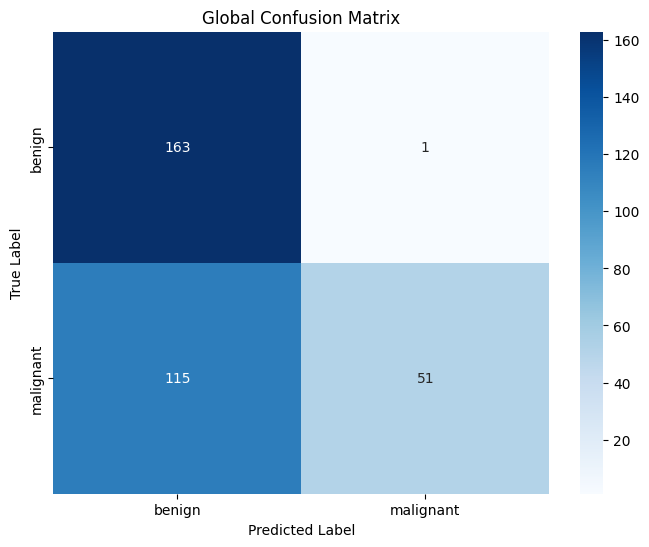

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Global Confusion Matrix')
plt.show()

## Model Saving to GDrive

In [94]:
import shutil
import os

source_dir = "/content/global_models/"
destination_dir = "/content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/FL_Global_Models/Inception_V3"

os.makedirs(destination_dir, exist_ok=True)

for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(destination_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print(f"Copied contents of {source_dir} to {destination_dir}")

Copied contents of /content/global_models/ to /content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/FL_Global_Models/Inception_V3


### Reverse Load again if need in future

In [95]:
import shutil
import os

destination_dir = "/content/global_models/"
source_dir = "/content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/FL_Global_Models/Inception_V3"

os.makedirs(destination_dir, exist_ok=True)

for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(destination_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print(f"Copied contents of {source_dir} to {destination_dir}")

Copied contents of /content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/FL_Global_Models/Inception_V3 to /content/global_models/
